# Hands-on Notebook for WQRN3 Tutorial: ゼロから作る量子ネットワーク


このノートブックは、慶應義塾大学のNaphan Benchasattabuse (whit3z)、Ryosuke Satoh (cocori)、Rodney Van Meterによって書かれました。

このノートブックは [Creative Commons Attribution license (CC BY 4.0 license)](https://creativecommons.org/licenses/by/4.0/)　の下でライセンスされています。



# Jupyterノートブックの使い方

Jupyterノートブックにはコードセルとテキストセルの2種類のセルがあります。

コードセルではコードを書いて実行することができます（ここではPython）。コードを実行するためには、ランタイムもしくはカーネルを起動する必要があります。通常、ランタイムは自動的に起動します。書かれたコードはランタイムによって実行され、変数が保存されます。一度保存された変数は、たとえセルを消したとしても残り続けていることに気をつけてください。すべての変数を消して最初の状態にしたいときは、ランタイムを再起動してください。各セルは、どのような順序でも実行することができます。したがって、わざとノートブックに書かれた順番通りに実行しなかった場合、エラーや意図しない挙動をすることがあります。

テキストセルは、コードセルに対するコメントやドキュメンテーションとして使われます。また今あなたが読んでいるこのセルのように、ノートブックを通してあなたの考えを導くためのメモや説明として使うこともできます。

### ノートブックの歩き方

- `shift + enter` でコードセルの内容を実行したり、テキストセルを描画してから、次のセルにフォーカスすることができます。
- `print()` コマンドがない場合、コードセルの最後の行の出力が表示されます。

### 基本的なトラブルシューティング

- もしコードセルを実行してエラーが出た場合、その前のセルで宣言されている変数にアクセスしようとしているか確認してください。もしそうであれば、その前のセルがすでに実行されているか確認してください。

### 下にある最初のセルを実行してみましょう

コードセルは、そのセルの前にある `[ ]`　にマウスをホバーさせたときに表示される "再生" アイコンをクリックすることで実行できます。コードセルを実行後、カッコの中に数字が表示されます。この数字は、これまで何個のセルを実行したかを表しています。もしこれが、あなたが新たに起動したランタイムであれば、`[1]` と表示されるはずです。

次のセルの出力は `5` となるはずです。

In [ ]:
## 数字を足してみましょう
2 + 3

### 必要なライブラリをインストールするために、下のセルを実行してください

量子コンピューティングをシミュレートし、出力統計を可視化するために、[Qiskit](https://qiskit.org/documentation/locale/ja_JP/tutorials/circuits/1_getting_started_with_qiskit.html)を使用します。

In [ ]:
!pip install qiskit
!pip install pylatexenc

Template code and some helper functions

In [ ]:
# 必要なライブラリをインポートします
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute 
from qiskit.visualization import plot_histogram
from qiskit import user_config
from qiskit.quantum_info import partial_trace
import numpy as np
import random

# 量子回路を可視化するためにシミュレーターを初期化します
sv_sim = Aer.get_backend('statevector_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')

# mplを量子回路の可視化にデフォルトで使用します
%env QISKIT_SETTINGS {}
user_config.set_config('circuit_drawer', 'mpl')

In [ ]:
# スタンドアローンのノートブックでも動作させるためのヘルパー関数(modified by whit3z)
def show_info(qc, use_statevector_only=False):
    """この関数は、quantum circuitオブジェクトを受け取り、counts / statevectorを出力します"""
    qc_remove_measurement = qc.remove_final_measurements(inplace=False)
    counts = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=10000).result().get_counts()
    statevector = execute(qc_remove_measurement, backend=Aer.get_backend('statevector_simulator')).result().get_statevector()
    print('====== state_vector ======')
    display(statevector.draw(output='latex'))
    print('')
    print('====== true probability distribution =====')
    display(plot_histogram({k: np.abs(v) ** 2 for k, v in statevector.to_dict().items()}, title='true probability distribution', color='midnightblue'))
    print('====== counts from measurements ======')
    display(plot_histogram(counts, title='readout results histogram'))

def show_info_partial(qc, qubit_list, use_statevector_only=False):
    pass

noise_rate = 0.2
def noisyCX(self, a, b):
    self.cx(a, b)
    if random.random() < noise_rate:
        self.x(b)

QuantumCircuit.noisyCX = noisyCX

カスタムLaTeXコマンドを作ります

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$


# 量子ゲートの基本 (ユニタリー演算)
---

量子計算における基本操作は、古典的な低レベルのビット列処理のようなビット単位の演算（例えば、and、or、not、xorなど）ではありません。

量子状態はヒルベルト空間上の単位ベクトルとして定義されているため、線形代数のように、ベクトル上で作用する演算は、行列（線形作用素）として定義できます。演算後の新しい状態ベクトルは、有効な状態ベクトルであってほしく、この制約を保つために、その演算子（あるいは行列）はユニタリーである必要があります。


## 量子回路を定義する

量子計算の回路モデルにおいて、まずはじめに量子回路を定義しなければ、状態を定義することができません。

Qiskitでは、下のセルの例のように量子回路を定義することができます。

量子回路を定義するには、2つの主な方法があります。

1. 簡単な記法 `QuantumCircuit(<#qubit>, <#classical_bit>)` を使って回路を定義し、そのあとで回路中の量子ビットに添字（インデックス）でアクセスする方法
2. 最初にレジスターを定義して、それらを使って量子回路を初期化する方法

レジスターに名前を付ける二つ目の方法は、複数の量子ビットを取り扱い、それらを用途に応じて分けて使う場合に便利です。あとで量子テレポーテーションを扱う時にわかりやすくするために、この方法を使います。

In [ ]:
# シンプルな1量子ビットの量子回路を作ります

# 簡単な記法
shorthand_circuit = QuantumCircuit(1, 1) # 1量子ビット, 読み出しのための古典の1bit

# レジスタから組み立てる方法
q_reg = QuantumRegister(1, 'qreg')
c_reg = ClassicalRegister(1, 'creg')
qc = QuantumCircuit(q_reg, c_reg)

### Exercise: あなたの量子回路を定義しましょう

上に示した方法を用いて、新しい量子回路を作ってみましょう。二つ以上の量子レジスタを含む回路を作ってください。

In [ ]:
"""Exercise: Try creating circuits here"""
q_reg2 = QuantumRegister(2, 'qreg')
c_reg2 = QuantumRegister(2, 'creg')
qc2 = QuantumCircuit(q_reg2, c_reg2)


## 量子ゲートを適用する

では、いくつかの単一量子ビットゲートをみてみましょう。

Identityゲート (何もしないゲート)

$I=\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]$

3つのパウリ行列 (パウリゲート)

$
X=\sigma_{x}=\left[\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right], \\
Y=\sigma_{y}=\left[\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right], \\
Z=\sigma_{z}=\left[\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right] .
$

パウリXは、古典におけるNOTゲートに相当するゲートです。

アダマールゲート(Hadamard gate, H)は、重ね合わせを作るためによく使われます。

$H=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]$

`qc.h(<qubit_index>)` を使って、$ H \ket{0}$ から $\ket{0}$ と $\ket{1}$ の間の重ね合わせ状態を作り出すためには、

In [ ]:
# 一様な重ね合わせを作ります。

qc = QuantumCircuit(1, 1)
qc.h(0)

その他のゲートも同じように呼ぶことかできます。

`QuantumCircuit.x()` `QuantumCircuit.y()` `QuantumCircuit.z()`

[RY gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RYGate.html)のような、一様ではない重ね合わせを定義するための便利なゲートがあります。これは、RY gateは角度を調整できるPauli Y演算子です。

$RY(\theta)=\exp \left(-i \frac{\theta}{2} Y\right)=\left(\begin{array}{cc}\cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \\ \sin \frac{\theta}{2} & \cos \frac{\theta}{2}\end{array}\right)$

同様に [Rx](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html) と [Rz](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZGate.html) もあります。


Note: Qiskitで定義されている他のゲートは[ここ](https://qiskit.org/documentation/apidoc/circuit_library.html)で確認できます。

## 量子回路の描画

量子回路を描画するには、`.draw()` コマンドを使います。

In [ ]:
# 初期化
qc = QuantumCircuit(1, 1)
qc.h(0)

# 描画
qc.draw()

### Exercise: 量子回路を作って描画する

2量子ビットの回路を作ってみてください。1つ目の量子ビットにXをかけてから、Zをかけます。そして2つ目の量子ビットにはHをかけます。

In [ ]:
""" Exercise: Fill in your code here """


## 量子ビットの測定によって回路から情報を得る

量子システムや量子状態から有益な情報を得るためには、量子状態に対して測定を行う必要があります。私たちが得られる、注目に値する情報は **古典的情報です**

measurement can be done in Qiskit by calling . So far we have define our circuits to have classical bits but never used it, now we get to see why we need classical bits in our circuits.
測定は、`QuantumCircuit.measure(<qubit>, <classical_bit>)` を呼び出すことでQiskitの中で行われます。ここまで私たちは回路中に古典ビットを定義していましたが、使っていませんでした。ここでは、なぜ古典ビットが必要だったかをみていきます。

In [ ]:
# 初期化
qc = QuantumCircuit(1, 1)
qc.h(0)

# 測定を追加します
qc.measure(0, 0)
qc.draw()

最後に計測を付けた回路を渡されると、読み出し分布の出力（このヘルパー関数は量子回路を1万回実行します）と、最後の計測の直前の状態ベクトルを出力するヘルパー関数を提供します。


`show_info(qc)` と呼び出すことができます。

In [ ]:
# show_info(qc)

qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])
show_info(qc)
qc.draw()

### ketのエンディアンと回路図における表記

ある複数の量子ビットを含む回路は下の図のようになります

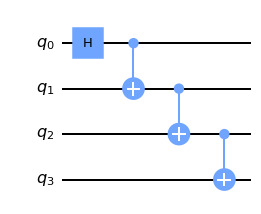

この場合、回路中の上から下に並ぶ量子ビットを、それぞれ左から右へ書くと、状態ベクトルは $\ket{q_0, q_1, q_2, q_3}$ と書けるでしょう（ビッグエンディアン記法）。

しかし、計算機科学におけるビット列や2進数の記法にしたがって上位ビット（most significant bit MSB)を左側に置くリトルエンディアン記法を用いた場合、状態ベクトルは $\ket{q_3, q_2, q_1, q_0}$ と書けるでしょう。 

Qiskitはデフォルトで $q_0$ を一番上に描画し、レジスタに最後に書き込むようになっています。

エンディアンについて詳しくは [wikipedia page](https://ja.wikipedia.org/wiki/%E3%82%A8%E3%83%B3%E3%83%87%E3%82%A3%E3%82%A2%E3%83%B3)

記法について詳しくは [Qiskit textbook](https://qiskit.org/textbook/ja/ch-states/representing-qubit-states.html)

# 量子もつれとベル状態
---

2量子ビットの最大エンタングル状態あるいはペルペアが、S値(CHSH不等式)が $2\sqrt{2}$ となる4つの異なる形式をもつことを思い出してください。

$\begin{aligned}
\left|\Phi^{+}\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)
\\
\left|\Phi^{-}\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle-|11\rangle)
\\
\left|\Psi^{+}\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle+|10\rangle)
\\
\left|\Psi^{-}\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle-|10\rangle)
\end{aligned}$

## ペル状態をの生成

最もよく知られたペルペアの形は $\Phi^+$ です。この状態は、次のコードで作ることができます。

In [ ]:
# phi+ の回路

qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0,1], [0, 1])

# 回路とその出力を表示します
display(qc.draw())
show_info(qc)

### 2量子ビットゲート(CNOTゲート)

上の回路には、初めて出てくるゲート、CNOTがあります。

CNOTあるいはCXゲートは、次の行列で定義されます。

$\mathrm{CNOT}=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0\end{array}\right]$

この行列では、量子ビットの順序はQiskitの表記法に従っています。

一般的な教科書などでは、次のようにビッグエンディアンで書かれているでしょう。

$\mathrm{CNOT}=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right]$

2量子ビットゲートがなければ、量子力学の奇妙さの基本であり、古典コンピューティングに対する優位性の肝となる量子もつれを作ることができません。

### 量子回路の合成

これまで、私たちは毎回新しい変数を用意し、そこへQiskitにある基本的なゲートをかけて、新たな量子回路を作ってきました。

小さな部品を作ってから、それらを組み合わせてより大きな量子回路を作ろうとしたときに、今までのやり方はよくありません。

あとで使うための量子回路を定義し、それらを組み合わせて使う方法を下のコードに示します。
それでは、$\Phi_+$ 状態を作成する例をみてみましょう。

In [ ]:
# Phi+ を作成する回路

phi_plus_circ = QuantumCircuit(2)
phi_plus_circ.h(0)
phi_plus_circ.cx(0, 1)

# 2量子ビットを測定するための回路

two_qubit_measurment_circ = QuantumCircuit(2, 2)
# two_qubit_measurment_circ.barrier()
two_qubit_measurment_circ.measure([0, 1], [0, 1])

# 二つの回路をそれぞれ分けて表示する
print('phi plus circ')
display(phi_plus_circ.draw())
print('two qubit measurement circ')
display(two_qubit_measurment_circ.draw())


# 二つの回路を組み合わせて一つの回路にする
## まずはじめに、新たな回路を用意する

qc = QuantumCircuit(2, 2)
qc = qc.compose(phi_plus_circ)
qc = qc.compose(two_qubit_measurment_circ)
print('the composed circuit')
qc.draw()

### Exercise: $\Phi^-$ 状態を作成する

In [ ]:
# Phi- の作成

phi_minus_circ = QuantumCircuit(2)

"""Complete the code"""


"""End"""

# 測定結果と量子回路を表示します
qc = QuantumCircuit(2, 2)
qc = qc.compose(phi_minus_circ).compose(two_qubit_measurment_circ)
qc.draw()
show_info(qc)

### Exercise: $\Psi^+$ 状態を作成する

In [ ]:
# Psi+ の作成

psi_plus_circ = QuantumCircuit(2)

"""Complete the code"""


"""End"""

# 測定結果と量子回路を表示します
qc = QuantumCircuit(2, 2)
qc = qc.compose(psi_plus_circ).compose(two_qubit_measurment_circ)
qc.draw()
show_info(qc)

### Exercise: $\Psi^-$ 状態を作成する

In [ ]:
# Psi- の作成

psi_minus_circ = QuantumCircuit(2)

"""Complete the code"""



"""End"""

# 測定結果と量子回路を表示します
qc = QuantumCircuit(2, 2)
qc = qc.compose(psi_minus_circ).compose(two_qubit_measurment_circ)
qc.draw()
show_info(qc)

## ベル状態測定器 (Bell State Analyzer)
---

仮にベルペアがあるとして、しかしそのペルペアが4つの取り得る状態のうちどれかわからないとき、**ベル測定**（レッスン13のステップ2の動画で学びました）と呼ばれる特殊な測定を行うことで、どの状態かを特定することができます。Qiskitでは測定がZ基底（計算基底）で行われることを思い出してください。私たちの仕事は、ベル基底をZ基底に変えるユニタリーを実装することです。


つまり、それぞれの形を下の表のようなベル状態で読み替えるということです。

| Bell state                          |   q0,q1 (eigenvalues) | output from the circuit |
|---------                            |--------------         | -------------           |
| $\left\vert\Phi^{+}\right\rangle$   | +1,+1                 | 00                      |
| $\left\vert\Phi^{-}\right\rangle$   | +1,-1                 | 01                      |
| $\left\vert\Psi^{+}\right\rangle$   | -1,+1                 | 10                      |
| $\left\vert\Psi^{-}\right\rangle$   | -1,-1                 | 11                      |


**上の表は有効な対応関係の一つであり、4つのベル状態から4つの計算基底への1対1の対応関係はどれも同じように機能します。**

### 追記

もしあなたが線形代数に慣れ親しんでいれば、実装しなければならないそのユニタリーは基底の変換行列と同じものであることを思い出したかもしれません。
この素晴らしい[動画](https://youtu.be/P2LTAUO1TdA)では、基底の変換についてより詳しく知ることができます。

### Exercise: BSA回路を作成する
Note: 測定をこのBSAコンポーネントに追加しないでください。測定は、あとで別のコンポーネントに追加します。

In [ ]:
bell_state_analyser_circuit = QuantumCircuit(2)

"""Complete the code"""



"""End"""

bell_state_analyser_circuit.draw()

### 作成したBSA回路をテストする

それでは、作成したBSA回路が期待した通りに動くかどうか試してみましょう。この回路は、上のテーブルと同じ測定結果を出力するはずです。
**この下にある4つのコードセルは、変更する必要がありません。**

In [ ]:
## Phi+をテストする

qc = QuantumCircuit(2, 2)
qc = qc.compose(phi_plus_circ).compose(bell_state_analyser_circuit).compose(two_qubit_measurment_circ)
display(qc.draw())
show_info(qc)

In [ ]:
## Phi-をテストする

qc = QuantumCircuit(2, 2)
qc = qc.compose(phi_minus_circ).compose(bell_state_analyser_circuit).compose(two_qubit_measurment_circ)
display(qc.draw())
show_info(qc)

In [ ]:
## Psi+をテストする

qc = QuantumCircuit(2, 2)
qc = qc.compose(psi_plus_circ).compose(bell_state_analyser_circuit).compose(two_qubit_measurment_circ)
display(qc.draw())
show_info(qc)

In [ ]:
## Psi-をテストする

qc = QuantumCircuit(2, 2)
qc = qc.compose(psi_minus_circ).compose(bell_state_analyser_circuit).compose(two_qubit_measurment_circ)
display(qc.draw())
show_info(qc)

**ベル状態の違いを見分けるための4つの回路の出力は正しいでしょうか？**

# 量子テレポーテーション

---

ある物体を別の場所へ一瞬で移動させる、テレポートというものを聞いたことがあるでしょう。幸か不幸か、量子テレポーテーションは一瞬で起こるものではありませんし、物体ではなく量子データを移動させる現象です。さらに、移動というのも厳密には違います。量子テレポーテーションは一つのベルペアを消費して、ある量子状態を**破壊**し、同じ量子状態を違う場所で**再生成**します。これは、光速を超える通信を実現**できません**が、その理由は後ほど説明します。

AliceとBobがいるとします。AliceとBobはすでにペルペアを作って共有しています。Aliceは、Bobに送りたいデータ量子ビット（量子状態）を持っているとします。まず、Aliceは既に作ったBSA回路を使って、彼女の持っているデータ量子ビットと彼女持っているベルペアの半分を担う量子ビットに対してベル測定を行います。Aliceが測定を行なった後、彼女はその結果をなんらかの方法でBobに送ります。BobはAlice側でのタスクが終わったことを知ったら、その情報を用いて、すでに破壊されたペルペアのうちBob側の量子ビットに対してある操作（パウリ訂正、もしくは訂正フレーム）を行います。この操作によって、最初にAliceのデータ量子ビットにあった量子状態は、Bobの量子ビットに出現します。これが量子テレポーテーションの一連の流れとなります。

それでは、各ステップごとに何が起きていたのかを分析してみましょう。

1. AliceとBobはベルペアを共有していなければいけません（この例では、$\Phi_+$ 状態とします）
1. Aliceはデータ量子ビットを用意します $\ket{\Psi} = \alpha \ket{0} + \beta \ket{1}$
1. Aliceはベルペアの片方とデータ量子ビットに対してベル測定を行います。

<!-- Let's pause here for a bit and write the states out and for simplicity of writing we will drop the $1 / \sqrt{2}$ in factor of the Bell state

$\begin{aligned}
\ket{0_A 0_B} + \ket{1_A 1_B}
\\
\ket{\Psi} \otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right)
\\
( \alpha \ket{0_{A'}} + \beta \ket{1_{A'}} ) \otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right)
\\
( \alpha \ket{0_{A'}} + \beta \ket{1_{A'}} ) \otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right)
\\
\alpha \ket{0_{A'}} \otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right) + \beta \ket{1_{A'}}\otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right)
\\
\alpha \ket{0_{A'} 0_A 0_B} + \alpha \ket{0_{A'} 1_A 1_B} + \beta \ket{1_{A'} 0_A 0_B} + \beta \ket{1_{A'} 1_A 1_B}
\end{aligned}$ -->

ここで少し立ち止まって、全ての初期状態を書き出してみましょう。

$\begin{aligned}|\psi\rangle_{A_{1}}\left|\Phi^{+}\right\rangle_{A_{2} B} &=(\alpha|0\rangle+\beta|1\rangle)_{A_{1}} \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)_{A_{2} B} \\ &=\frac{1}{\sqrt{2}}(\alpha|000\rangle+\alpha|011\rangle+\beta|100\rangle+\beta|111\rangle)_{A_{1} A_{2} B} \end{aligned}$

4つのベル状態を計算基底で書き出すと次のように書けることを私たちは既に知っています。

$\left|\Phi^{+}\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle) \quad\left|\Phi^{-}\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle-|11\rangle)$
$\left|\Psi^{+}\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle+|10\rangle) \quad\left|\Psi^{-}\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle-|10\rangle)$

あるいは、計算基底で書かれた状態を、ベル基底では次のように書けます。

$\begin{array}{ll}|00\rangle=\frac{1}{\sqrt{2}}\left(\left|\Phi^{+}\right\rangle+\left|\Phi^{-}\right\rangle\right) & |01\rangle=\frac{1}{\sqrt{2}}\left(\left|\Psi^{+}\right\rangle+\left|\Psi^{-}\right\rangle\right) \\ |10\rangle=\frac{1}{\sqrt{2}}\left(\left|\Psi^{+}\right\rangle-\left|\Psi^{-}\right\rangle\right) & |11\rangle=\frac{1}{\sqrt{2}}\left(\left|\Phi^{+}\right\rangle-\left|\Phi^{-}\right\rangle\right)\end{array}$

Using above trick, we can rewrite the states as
これらのテクニックを使って、冒頭にとりあげた初期状態を書き直してみると、

$\begin{aligned}|\psi\rangle_{A_{1}}\left|\Phi^{+}\right\rangle_{A_{2} B}=&(\alpha|0\rangle+\beta|1\rangle)_{A_{1}} \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)_{A_{2} B} \\=& \frac{1}{\sqrt{2}}(\alpha|000\rangle+\alpha|011\rangle+\beta|100\rangle+\beta|111\rangle)_{A_{1} A_{2} B} \\=& \frac{1}{\sqrt{2}}\left(\alpha\left(\left|\Phi^{+}\right\rangle+\left|\Phi^{-}\right\rangle\right)|0\rangle\right.\\ &+\alpha\left(\left|\Psi^{+}\right\rangle+\left|\Psi^{-}\right\rangle\right)|1\rangle \\ &+\beta\left(\left|\Psi^{+}\right\rangle-\left|\Psi^{-}\right\rangle\right)|0\rangle \\ &+\beta\left(\left|\Phi^{+}\right\rangle-\left|\Phi^{-}\right\rangle\right)|1\rangle \end{aligned}$

そして、いくつかの項を括り直して整理してみると、次のような結果を得ます。

$\begin{aligned}|\psi\rangle_{A_{1}}\left|\Phi^{+}\right\rangle_{A_{2} B} &=\frac{1}{2}\left|\Phi^{+}\right\rangle_{A_{1} A_{2}}(\alpha|0\rangle+\beta|1\rangle)_{B} \\ &+\frac{1}{2}\left|\Phi^{-}\right\rangle_{A_{1} A_{2}}(\alpha|0\rangle-\beta|1\rangle)_{B} \\ &+\frac{1}{2}\left|\Psi^{+}\right\rangle_{A_{1} A_{2}}(\alpha|1\rangle+\beta|0\rangle)_{B} \\ &+\frac{1}{2}\left|\Psi^{-}\right\rangle_{A_{1} A_{2}}(\alpha|1\rangle-\beta|0\rangle)_{B} \end{aligned}$

したがって、4つのベル基底状態の出力は同様に確からしいことがわかります。そして、Aliceがどの測定結果を得たかによって、Bobのもっている状態は、ビットか位相、あるいはその両方が反転していることがわかります。

ここで、私たちは状態に対してなにもしていないことに気を付けてください。ただ、初期状態の項を書き直して、括り直しただけなのです！

## Is Teleportation instantaneous?

Initially, Bob has one qubit and from his view point it's in the state

$\left|\Phi^{+}\right\rangle_{A_{2} B}=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle) \longrightarrow \rho_{B}=\frac{1}{2}|0\rangle\left\langle 0\left|+\frac{1}{2}\right| 1\right\rangle\langle 1|$

which is a maximally mixed state.

Then just before Alice performs the measurement, the state is in 

$\frac{1}{2}\left|\Phi^{+}\right\rangle_{A_{1} A_{2}}(\alpha|0\rangle+\beta|1\rangle)_{B}+\frac{1}{2}\left|\Phi^{-}\right\rangle_{A_{1} A_{2}}(\alpha|0\rangle-\beta|1\rangle)_{B}$
$+\frac{1}{2}\left|\Psi^{+}\right\rangle_{A_{1} A_{2}}(\alpha|1\rangle+\beta|0\rangle)_{B}+\frac{1}{2}\left|\Psi^{-}\right\rangle_{A_{1} A_{2}}(\alpha|1\rangle-\beta|0\rangle)_{B}$

But what about Bob's state just right after the measurement?

$\operatorname{Prob}\left(\left|\Phi^{+}\right\rangle\right)=1 / 4, \quad$ Bob has $\alpha|0\rangle+\beta|1\rangle$
$\operatorname{Prob}\left(\left|\Phi^{-}\right\rangle\right)=1 / 4, \quad$ Bob has $\alpha|0\rangle-\beta|1\rangle$
$\operatorname{Prob}\left(\left|\Psi^{+}\right\rangle\right)=1 / 4, \quad$ Bob has $\alpha|1\rangle+\beta|0\rangle$
$\operatorname{Prob}\left(\left|\Psi^{-}\right\rangle\right)=1 / 4, \quad$ Bob has $\alpha|1\rangle-\beta|0\rangle$

So if we look at Bob's viewpoint again on the state he's holding

$\begin{aligned} \rho_{B} &=\frac{1}{4}(\alpha|0\rangle+\beta|1\rangle)\left(\alpha^{*}\langle 0|+\beta^{*}\langle 1|\right) \\ &+\frac{1}{4}(\alpha|0\rangle-\beta|1\rangle)\left(\alpha^{*}\langle 0|-\beta^{*}\langle 1|\right) \\ &+\frac{1}{4}(\alpha|1\rangle+\beta|0\rangle)\left(\alpha^{*}\langle 1|+\beta^{*}\langle 0|\right) \\ &+\frac{1}{4}(\alpha|1\rangle-\beta|0\rangle)\left(\alpha^{*}\langle 1|-\beta^{*}\langle 0|\right) \end{aligned}$

then 

$\begin{aligned} \rho_{B} &=\frac{1}{2}\left(|\alpha|^{2}+|\beta|^{2}\right)|0\rangle\langle 0| \\ &+\frac{1}{2}\left(|\alpha|^{2}+|\beta|^{2}\right)|1\rangle\langle 1| \\ &=\frac{1}{2}|0\rangle\left\langle 0\left|+\frac{1}{2}\right| 1\right\rangle\langle 1| \end{aligned}$

Which is still a maximally mixed state!

So the teleportation hasn't taken placed yet just after Alice performing the measurement. 

Even when Alice sends the results, the measurement still hasn't taken place until Bob finally gets the results. At that point then we can say that the teleporation has finally taken place. 

**So teleportation doesn't violate the faster-than-light communication restriction because the Pauli correction message speed is still limited by the speed of light.**

Now that we understand the theory behind the teleportation procedure, let's try to simulate it in the circuit form.

### Exercise: Initialize Alice's data qubit

Let's try to pick some random state with non-uniform superposition of $\ket{0}$ and $\ket{1}$ by using Ry gate.
Try and pick $\theta$ you want and we will use this same state for Alice in our teleportation circuit.

In [ ]:
alice_qubit_circ = QuantumCircuit(1, 1)

"""Choose your own theta"""
## Begin
# Change 0 to your value of choice!

theta = 1

## End


alice_qubit_circ.ry(theta, 0)
alice_qubit_circ.measure(0, 0)

display(alice_qubit_circ.draw())
show_info(alice_qubit_circ, use_statevector_only=True)

### Exercise: Initialize Alice's data qubit using the $\theta$ we picked

This time we will use register naming approach to create the circuit so we get a clearer picture of whose qubits are we working on.

In [ ]:
# Creating Alice register
alice = QuantumRegister(2, "alice")
bob = QuantumRegister(1, "bob")
creg = ClassicalRegister(2) # So we can see the results
qc = QuantumCircuit(alice, bob, creg)

"""Complete the Code below"""
# reminder if you want to apply x on alice's data qubit it can be done via qc.x(alice[0])


"""End"""

qc.draw()

### Exercise: Create a Bell pair between Alice and Bob

In [ ]:
"""Complete the Code below"""

# qc.


"""End"""

qc.draw()

### Exercise: Perform Bell state measurement on Alice's qubits

In [ ]:
"""Complete the Code below"""

# qc.


"""End"""

qc.draw()

### Exercise: Apply Pauli correction on Bob's qubit

So far we've only done measurement at the very end of a circuit. It should be noted that it is possible to perform a measurment in the middle of the circuit and depending on the classical readout make a decision on what to perform next based on that. This is referred to as feed-forward operation. 

Noted that this feed-forward is not available on most real devices yet.

To append a gate based on values inside classical register, it can be done using `qc.gate(qreg[index]).c_if(<creg_bit>, <creg_value>)`. For example if we want to apply X to Alice's data qubit (qubit 0) if data in creg[1] equals 1, we can do so by `qc.x(alice[0]).c_if(creg[1], 1)`

In [ ]:
"""
Take note on which creg you store the BSA results and apply the c_if on the correct creg index.
Complete the Code below
"""


"""End"""

qc.draw()

### Exercise: Verify if our teleportation procedure is correct or not!

If everything we've done so far is correct we should see two statevector plots / state equations to be the same
and a message confirming the results at the end of the output.

In [ ]:
# check equal ignore global phase via statevector method
alice_data_qubit_sv = execute(alice_qubit_circ.remove_final_measurements(inplace=False), backend=Aer.get_backend('statevector_simulator')).result().get_statevector()
whole_circuit_sv = execute(qc, backend=Aer.get_backend('statevector_simulator')).result().get_statevector()
bob_final_qubit_sv = partial_trace(whole_circuit_sv, [0, 1]).to_statevector()
# print(f'alice state vector = {alice_data_qubit_sv.draw()}')
# print(f'bob state vector = {bob_final_qubit_sv.draw()}')
if bob_final_qubit_sv.equiv(alice_data_qubit_sv):
    print('Congratulations! You made the teleportation works!')
else:
    print('You probably made something wrong!')

display(plot_histogram({k: np.abs(v) ** 2 for k, v in alice_data_qubit_sv.to_dict().items()}, title='Alice distribution', color='midnightblue'))
display(plot_histogram({k: np.abs(v) ** 2 for k, v in bob_final_qubit_sv.to_dict().items()}, title='Bob distribution', color='midnightblue'))

# Entanglement Swapping
---

Entanglment swapping is the heart of quantum network protocols. It is used to create long distance Bell pairs.

A simple but not quite accurate description of it is that if we have two Bell pairs where one person is holding one end of both pairs, they can stitch the Bell pair together creating a longer Bell pair. 


Let say we have three people, Alice, Bob and Clare.


Both Alice and Clare create create a Bell pair each, they send one qubit of their Bell pair to Bob.


Bob then performs a Bell state measurement and send the measurement result to Alice or Clare or both so that the two can apply corrections on their qubits if needed. 


This results is used to select which unitary (x, z) is used on, say Alice's, initial qubit. Doing so, entangling Alice's qubit with Clare's initial one.

It looks like what Bob did was to stitch the two pairs together, but what actually happens is that Bob performs teleportation on Alice's (or Clare's qubit) to Clare's (Alice's). 


### Noted
You should write all the operations, Bell state creation, Bell state analyzer from scratch here to help improve and test your understanding from above exercises.

### Exercise Complete the code block below

In [ ]:
#Create the initial state
alice = QuantumRegister(1, "alice")
bob = QuantumRegister(2, "bob")
clare = QuantumRegister(1, "clare")
creg = ClassicalRegister(2)  # Classical Register to store Bob's measurement results
qc = QuantumCircuit(alice, bob, clare, creg)


# Make entanglement between Alice-Bob
"""Write your code here"""
qc.h(alice[0])
qc.cnot(alice[0],bob[0])


# Make entanglement between Bob-Clare
"""Write your code here"""
qc.h(bob[1])
qc.cnot(bob[1],clare[0])


# Bob applies BSA on his qubits
"""Write your code here"""
qc.cnot(bob[0],bob[1])
qc.h(bob[0])

# Bob measure his qubits
"""Write your code here"""
qc.measure(bob[0],creg[0])
qc.measure(bob[1],creg[1])


# Bob sends out his results. Use c_if() to simulate the idea of getting the results and apply the correction for it
qc.x(clare[0]).c_if(creg[1],1)
qc.z(clare[0]).c_if(creg[0],1)



### Exercise: Add code to measure out the two remaining qubits. Do the results match what you expect?

Run the code below to see if the final state between Alice and Clare is actually a $\ket{\Phi}^+$ Bell pair.

In [ ]:
# check equal ignore global phase via statevector method

final_sv = execute(qc, backend=Aer.get_backend('statevector_simulator')).result().get_statevector()
phi_plus_sv = execute(phi_plus_circ, backend=Aer.get_backend('statevector_simulator')).result().get_statevector()
alice_clare_sv = partial_trace(final_sv, [1, 2]).to_statevector()

if alice_clare_sv.equiv(phi_plus_sv):
    print('Congratulations! You made the entanglement swapping works!')
else:
    print('You probably made something wrong!')

display(alice_clare_sv.draw(output='latex'))
display(plot_histogram({k: np.abs(v) ** 2 for k, v in alice_clare_sv.to_dict().items()}, title='Alice distribution', color='midnightblue'))

# Purification (エラー検知)

---

Purification is a form of error detection. 

Due to the imperfection in the process of geneting an entangled pair (Bell pair) and the noise from the environment which can affect and change the state of our Bell pair. The more imperfection in our generation process and the longer we keep the Bell pair in our memories, the less sure we are about the actual Bell pair states.

To increase our confidence that the Bell pair is still in the state we are expecting it to be, we can use purification process, which consumes 1 or more Bell pairs in order to find out whether our Bell pair in question is still in the correct state or not. 

It is an error detection process because, when we perform the purification protocol, it either tells us whether our Bell pair is likely in the correct state or it doesn't. It doesn't tell us about which error (e.g., bit flip, phase flip) happened. 

## ベルペアにノイズをのせる

As we mentioned earlier, Bell pairs aren't always perfect. We can simulate the idea that 80% of the times our Bell pairs are in the $\ket{\Phi_+}$ state and 20% of the times an X error occurs, so it becomes $\ket{\Psi_+}$ state.

We already provide a custom gate called `noisyCX()` which 20% of the times it automatically adds X gate on the control bit.

If we build our Bell pair using this `noisyCX()` we can simulate the effect of noisy (mixed state) Bell pair.

In [ ]:
def sample_faulty_bell_pair():
    counts = {}
    counts[f'$\Phi+$'] = 0
    counts[f'$\Psi+$'] = 0

    qcs = []
    for i in range(1000):
        qc = QuantumCircuit(2, 2)
        qc.h(0)
        qc.noisyCX(0, 1)
        qc.measure([0, 1], [0, 1])
        qcs.append(qc)
    job = execute(qcs, backend=Aer.get_backend('qasm_simulator'), shots=1)

    for cnt in job.result().get_counts():
        k = list(cnt.keys())[0]
        if k == '00' or k == '11':
            counts[f'$\Phi+$'] = counts[f'$\Phi+$'] + 1
        else:
            counts[f'$\Psi+$'] = counts[f'$\Psi+$'] + 1

    return counts
counts = sample_faulty_bell_pair()
plot_histogram(counts)

### Exercise: Create 2 Bell pairs using the NoisyCX

Complete the Bell pair creation circuit

**NOTE**: this circuit creation function is probabilistic, 20% of the times and X gate is added so try running it multiple times to see if the result changes or not!

In [ ]:
bp1 = QuantumRegister(2, 'bell_1')
bp2 = QuantumRegister(2, 'bell_2')
parity_check_creg = ClassicalRegister(2, 'parity_check')
bell_pair_creg = ClassicalRegister(2, 'bellpair_result_creg')


def prepare_two_noisy_bellpair():
    noisy_2_bp_circ = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)
    ### Complete the code here to create 2 Bell pairs using NoisyCX
    # noisy_2_bp_circ.noisyCX(x, y)




    ### END 
    return noisy_2_bp_circ



qc = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)
qc = qc.compose(prepare_two_noisy_bellpair())
qc.measure([*bp1, *bp2], [*bell_pair_creg, *parity_check_creg])
qc.draw()

### Exercise: Create Purification Circuit

We want to check the parity of the 1st Bell pair, and consume the 2nd Bell pair for parity check.

**NOTE: We want to use non-noisy CX for this case**

In [ ]:
bp1 = QuantumRegister(2, 'bell_1')
bp2 = QuantumRegister(2, 'bell_2')
parity_check_creg = ClassicalRegister(2, 'parity_check')
bell_pair_creg = ClassicalRegister(2, 'bellpair_result_creg')
purification_circ = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)

# purification_circ


## Perform the measurement on 2nd bell pair


### END 

qc = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)
qc = qc.compose(prepare_two_noisy_bellpair()).compose(purification_circ)
qc.measure([*bp1], [*bell_pair_creg])
qc.draw()

### Exercise: Complete the code block below to check if purification procedure succeed or fail

In [ ]:
def is_purification_successful():
    qc = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)
    qc = qc.compose(prepare_two_noisy_bellpair()).compose(purification_circ)
    qc.measure([*bp1], [*bell_pair_creg])
    
    job = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=1)
    cnt = job.result().get_counts()
    parity_check_value_str = list(cnt.keys())[0][3:]
    ### Complete the code here

    ## Make sure that success is assign a Boolean value (True, False)
    ## since we already make a meausrment to  use the value inside that!
    ## use value inside parity_check_value_str, it'll be in either
    ## '00', '01', '10', '11'

    success = False

    ### END
    return success, list(cnt.keys())[0][:2] # return success/failure + bp results

### Testing code
if type(is_purification_successful()[0]) == bool:
    print(f'Your code is probably correct!')
else:
    print(f'Your code might not be correct!')

### Exercise: The only thing left to do is test!

After adding the measurement to first Bell pair, try running the code below.

What it does is it tries to gather 1,000 successful purification runs and gather statistics on the readout of the first Bell pair. Noted that earlier when we didn't perform purification process, the Bell pairs were correct 80% of the time. Now we should see and increase in the fidelity (higher chance of seeing correct state).

The output also shows how many runs we actually did to gather the 1,000 purifed Bell pairs. Since purification is a probabilitic process, we see that sometimes it fails and sometimes it succeed.

In [ ]:
purified_bp = 0
counts = {}
counts[f'$\Phi+$'] = 0
counts[f'$\Psi+$'] = 0

while purified_bp < 1000:
    succ, res = is_purification_successful()
    if not succ:
        continue

    purified_bp += 1
    k = res    
    if k == '00' or k == '11':
        counts[f'$\Phi+$'] = counts[f'$\Phi+$'] + 1
    else:
        counts[f'$\Psi+$'] = counts[f'$\Psi+$'] + 1

plot_histogram(counts)

# Congratulations! You have finally made it to the end!

By now you should have grasped the basic concepts of quantum networking to a certain degree! We hope you liked this notebook and if you have any comments or suggestions feel free to tell us in the room or in slack. Any feedback is welcome!

Also we hope that you'll be interested in the area of quantum network and consider contributing to the field. We really need more people!